## Orlando OPD Crime Analysis

* Updates Note
    * Jan 25, 2022
        * Referenceed the Esri's Crime Analysis Solutions
        * Import the collected ACS data and merge it wiht the orlando crime data
        * Create scatter plots with the varaibles to check correlations
        * Troubleshooting on installing Geopandas
            * Could not solve -> instead solved the issue at R, and imported to Notebook
    * Jan 24, 2022
        * Manpulate ACS data and create new columns and maps by using R (OPD_Crime_Analysis_220124.R)
        * Craete a barplot for densities as well as a heatmap of crime incidents by day of week and hour of day
    * Jan 21, 2022
        * sovle the isuse on python environment: cannot install python module with pip install, conda install
            * => create new python environment: Command Prompt, conda create -k --clone arcgispro-py3 --name arcgispro-py3-clone
        * Research census data related to the crime data (modeling for crime)
        * Collect ACS in R and import them (OPD_Crime_Analysis_220121.R)
    * Jan 20, 2022 
        * Spatial join crime data with neighborhoods shapefile
        * Create a bar plot of crime cases by neighborhoods in 2020
    * Jan 19, 2022
        * Develop and re-organize analysis process
        * 3. Data Wrangling - 1) Read CSV, 2) Check data, 3) Clean data
    * Jan 18. 2022
        * Develop datetime analysis and create three plots

### 0. Configuration

In [169]:
# Import Modules
import requests
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from osgeo import osr
%matplotlib inline
plt.style.use('classic')
import json
import csv
import os
import ast
from arcpy import env
from arcgis.gis import GIS
from arcgis.features import SpatialDataFrame
from arcgis.geocoding import geocode
from arcgis.geometry import lengths, areas_and_lengths, project, Point, Polyline, Polygon, Geometry
from arcgis.features import GeoAccessor, GeoSeriesAccessor
from arcgis.geoprocessing import import_toolbox
from datetime import datetime
from datetime import datetime
from dateutil import parser
from scipy import stats

In [135]:
# LOG-IN TO ARCGIS ONLINE
gis = GIS("https://www.arcgis.com", "kjhoon", "Apotheosis3267!")

In [136]:
# Set the data path in this project
data_pth = r'C:/Users/KIM36105/Downloads/Orlando_Crime_Analysis'

### 1. Data Wrangling - Base

In [24]:
# CREATE BASEMAP
map1 = gis.map('Orlando, FL', 13)
map1.basemap = "satellite"
map1

MapView(layout=Layout(height='400px', width='100%'))

In [25]:
# IMPORT CSV & GET SUMMARY INFO OF DF
crime_df = pd.read_csv(r'C:/Users/KIM36105/Downloads/OPD_Crimes.csv')
crime_df1 = crime_df
crime_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238491 entries, 0 to 238490
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   Case Number                 238491 non-null  object
 1   Case Date Time              238489 non-null  object
 2   Case Location               238491 non-null  object
 3   Case Offense Location Type  238491 non-null  object
 4   Case Offense Category       238491 non-null  object
 5   Case Offense Type           238491 non-null  object
 6   Case Offense Charge Type    238491 non-null  object
 7   Case Disposition            238491 non-null  object
 8   Status                      238491 non-null  object
 9   Location                    228265 non-null  object
dtypes: object(10)
memory usage: 18.2+ MB


In [26]:
# CHECK DF
crime_df1.head()

,Case Number,Case Date Time,Case Location,Case Offense Location Type,Case Offense Category,Case Offense Type,Case Offense Charge Type,Case Disposition,Status,Location
0,2020-00000700,01/01/2020 03:44:00 PM,9400 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Open,Unmapped,NaN
1,2019-00002818,01/03/2019 08:22:00 AM,4900 Block of FIJI CIR,Residence/Single,Theft,All other larceny,Committed,Closed,Mapped,"(28.60235426, -81.43691172)"
2,2020-00004890,01/05/2020 09:48:00 AM,9300 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Closed,Unmapped,NaN
3,2020-00007368,01/07/2020 01:04:00 PM,4700 Block of N PINE HILLS RD,Apartment/Condo,Robbery,Robbery,Committed,Arrest,Mapped,"(28.60018728, -81.45147832)"
4,2020-00008073,01/08/2020 01:18:00 AM,9400 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Closed,Unmapped,NaN


In [27]:
# REMOVE UNNECESSARY STRINGS IN COORDINATE COLUMN
crime_df1['Location'] = crime_df['Location'].str.replace("(","")
crime_df1['Location'] = crime_df['Location'].str.replace(")","")
crime_df1.head()

D66140B0-0277-45FF-AE18-A787BE3D4AAF:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
D66140B0-0277-45FF-AE18-A787BE3D4AAF:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.


,Case Number,Case Date Time,Case Location,Case Offense Location Type,Case Offense Category,Case Offense Type,Case Offense Charge Type,Case Disposition,Status,Location
0,2020-00000700,01/01/2020 03:44:00 PM,9400 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Open,Unmapped,NaN
1,2019-00002818,01/03/2019 08:22:00 AM,4900 Block of FIJI CIR,Residence/Single,Theft,All other larceny,Committed,Closed,Mapped,"28.60235426, -81.43691172"
2,2020-00004890,01/05/2020 09:48:00 AM,9300 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Closed,Unmapped,NaN
3,2020-00007368,01/07/2020 01:04:00 PM,4700 Block of N PINE HILLS RD,Apartment/Condo,Robbery,Robbery,Committed,Arrest,Mapped,"28.60018728, -81.45147832"
4,2020-00008073,01/08/2020 01:18:00 AM,9400 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Closed,Unmapped,NaN


In [28]:
# CREATE SEPARTE COLUMNS FOR LATITUDE AND LONGITUDE
lat = []
lon = []

for row in crime_df1['Location']:
    try:
        lat.append(row.split(',')[0])
        lon.append(row.split(',')[1])
    except:
        lat.append(np.NaN)
        lon.append(np.NaN)

crime_df1['Latitude'] = lat
crime_df1['Longitude'] = lon
crime_df1.head()

,Case Number,Case Date Time,Case Location,Case Offense Location Type,Case Offense Category,Case Offense Type,Case Offense Charge Type,Case Disposition,Status,Location,Latitude,Longitude
0,2020-00000700,01/01/2020 03:44:00 PM,9400 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Open,Unmapped,NaN,NaN,NaN
1,2019-00002818,01/03/2019 08:22:00 AM,4900 Block of FIJI CIR,Residence/Single,Theft,All other larceny,Committed,Closed,Mapped,"28.60235426, -81.43691172",28.60235426,-81.43691172
2,2020-00004890,01/05/2020 09:48:00 AM,9300 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Closed,Unmapped,NaN,NaN,NaN
3,2020-00007368,01/07/2020 01:04:00 PM,4700 Block of N PINE HILLS RD,Apartment/Condo,Robbery,Robbery,Committed,Arrest,Mapped,"28.60018728, -81.45147832",28.60018728,-81.45147832
4,2020-00008073,01/08/2020 01:18:00 AM,9400 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Closed,Unmapped,NaN,NaN,NaN


In [29]:
# CREATE SEPARATE COLUMNS FOR DAY MONTH YEAR
crime_df1['Case Date Time'] = pd.to_datetime(crime_df1['Case Date Time'], format = '%m/%d/%Y %I:%M:%S %p')
crime_df1.head()

,Case Number,Case Date Time,Case Location,Case Offense Location Type,Case Offense Category,Case Offense Type,Case Offense Charge Type,Case Disposition,Status,Location,Latitude,Longitude
0,2020-00000700,2020-01-01 15:44:00,9400 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Open,Unmapped,NaN,NaN,NaN
1,2019-00002818,2019-01-03 08:22:00,4900 Block of FIJI CIR,Residence/Single,Theft,All other larceny,Committed,Closed,Mapped,"28.60235426, -81.43691172",28.60235426,-81.43691172
2,2020-00004890,2020-01-05 09:48:00,9300 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Closed,Unmapped,NaN,NaN,NaN
3,2020-00007368,2020-01-07 13:04:00,4700 Block of N PINE HILLS RD,Apartment/Condo,Robbery,Robbery,Committed,Arrest,Mapped,"28.60018728, -81.45147832",28.60018728,-81.45147832
4,2020-00008073,2020-01-08 01:18:00,9400 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Closed,Unmapped,NaN,NaN,NaN


In [30]:
# CREATE SEPARATE COLUMNS FOR YEAR, MONTH, DAY
crime_df1['Year'] = pd.DatetimeIndex(crime_df1['Case Date Time']).year
crime_df1['Month'] = pd.DatetimeIndex(crime_df1['Case Date Time']).month
crime_df1['Day'] = pd.DatetimeIndex(crime_df1['Case Date Time']).day
crime_df1.head()

,Case Number,Case Date Time,Case Location,Case Offense Location Type,Case Offense Category,Case Offense Type,Case Offense Charge Type,Case Disposition,Status,Location,Latitude,Longitude,Year,Month,Day
0,2020-00000700,2020-01-01 15:44:00,9400 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Open,Unmapped,NaN,NaN,NaN,2020.0,1.0,1.0
1,2019-00002818,2019-01-03 08:22:00,4900 Block of FIJI CIR,Residence/Single,Theft,All other larceny,Committed,Closed,Mapped,"28.60235426, -81.43691172",28.60235426,-81.43691172,2019.0,1.0,3.0
2,2020-00004890,2020-01-05 09:48:00,9300 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Closed,Unmapped,NaN,NaN,NaN,2020.0,1.0,5.0
3,2020-00007368,2020-01-07 13:04:00,4700 Block of N PINE HILLS RD,Apartment/Condo,Robbery,Robbery,Committed,Arrest,Mapped,"28.60018728, -81.45147832",28.60018728,-81.45147832,2020.0,1.0,7.0
4,2020-00008073,2020-01-08 01:18:00,9400 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Closed,Unmapped,NaN,NaN,NaN,2020.0,1.0,8.0


### 2. Sharing the spatially-enabled dataframe on the webs

In [ ]:
# DEFINE THE COLUMNS AS INTEGER 
crime_df1['Year'] = crime_df1['Year'].fillna(0)
crime_df1['Year'] = crime_df1['Year'].astype(int)
crime_df1['Month'] = crime_df1['Month'].fillna(0)
crime_df1['Month'] = crime_df1['Month'].astype(int)
crime_df1['Day'] = crime_df1['Day'].fillna(0)
crime_df1['Day'] = crime_df1['Day'].astype(int)
crime_df1.head()

In [ ]:
# CHEKC THE SUMMARY OF DATA
crime_df1.info()

In [ ]:
# CREATE SUBSET WITH 2020 YEAR
crime_df1_2020 = crime_df1.loc[:][crime_df1['Year'] == 2020]
crime_df1_2020.head()

In [ ]:
# READ INTO SPATIALLY ENABLED DATAFRAME SEDF
crime_sedf1_2020 = pd.DataFrame.spatial.from_xy(crime_df1_2020, 'Longitude', 'Latitude')
crime_sedf1_2020.head()

In [ ]:
# Plot the Crime SDEF and Check it
crime_sedf1_2020.spatial.plot(map1)

In [ ]:
# Export to ArcGIS Online Repository
Orlando_Crime = crime_sedf1_2020.spatial.to_featurelayer('Orlando_Crimes_2020')
Orlando_Crime

### 3. Data Wrangling

#### 1) Read CSV via different sources

In [138]:
# A. Read csv from the JSON API
crime_df0 =pd.read_json(r'https://data.cityoforlando.net/resource/4y9m-jbmz.json')
crime_df0.head()

,case_number,case_date_time,case_location,case_offense_location,case_offense_category,case_offense_type,case_offense_charge_type,case_deposition,status,location,:@computed_region_bgqw_styj,:@computed_region_gsfg_ku74,:@computed_region_u8wz_9eai
0,2020-00000700,2020-01-01 15:44:00,9400 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Open,Unmapped,NaN,NaN,NaN,NaN
1,2019-00002818,2019-01-03 08:22:00,4900 Block of FIJI CIR,Residence/Single,Theft,All other larceny,Committed,Closed,Mapped,"{'latitude': '28.60235426', 'longitude': '-81....",4.0,22.0,NaN
2,2020-00004890,2020-01-05 09:48:00,9300 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Closed,Unmapped,NaN,NaN,NaN,NaN
3,2020-00007368,2020-01-07 13:04:00,4700 Block of N PINE HILLS RD,Apartment/Condo,Robbery,Robbery,Committed,Arrest,Mapped,"{'latitude': '28.60018728', 'longitude': '-81....",NaN,NaN,NaN
4,2020-00008073,2020-01-08 01:18:00,9400 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Closed,Unmapped,NaN,NaN,NaN,NaN


In [139]:
# B. Read csv from the local drive
crime_df1 = pd.read_csv(r'C:/Users/KIM36105/Downloads/OPD_Crimes.csv')
crime_df1.head()

,Case Number,Case Date Time,Case Location,Case Offense Location Type,Case Offense Category,Case Offense Type,Case Offense Charge Type,Case Disposition,Status,Location
0,2020-00000700,01/01/2020 03:44:00 PM,9400 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Open,Unmapped,NaN
1,2019-00002818,01/03/2019 08:22:00 AM,4900 Block of FIJI CIR,Residence/Single,Theft,All other larceny,Committed,Closed,Mapped,"(28.60235426, -81.43691172)"
2,2020-00004890,01/05/2020 09:48:00 AM,9300 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Closed,Unmapped,NaN
3,2020-00007368,01/07/2020 01:04:00 PM,4700 Block of N PINE HILLS RD,Apartment/Condo,Robbery,Robbery,Committed,Arrest,Mapped,"(28.60018728, -81.45147832)"
4,2020-00008073,01/08/2020 01:18:00 AM,9400 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Closed,Unmapped,NaN


In [140]:
# C. Read csv from Cloud Database using SQL (IBM DB2)

# Service Credentials
# "username": "gtr22671"
# "password": "yeTtnClz98DSRKWv"
# "hostname": "55fbc997-9266-4331-afd3-888b05e734c0.bs2io90l08kqb1od8lcg.databases.appdomain.cloud"
# "port": 31929
# "database": "bludb"

#### 2) Check data structure and types & plan analysis process

In [141]:
# Check the dataframe fields briefly 
crime_df1.head()

,Case Number,Case Date Time,Case Location,Case Offense Location Type,Case Offense Category,Case Offense Type,Case Offense Charge Type,Case Disposition,Status,Location
0,2020-00000700,01/01/2020 03:44:00 PM,9400 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Open,Unmapped,NaN
1,2019-00002818,01/03/2019 08:22:00 AM,4900 Block of FIJI CIR,Residence/Single,Theft,All other larceny,Committed,Closed,Mapped,"(28.60235426, -81.43691172)"
2,2020-00004890,01/05/2020 09:48:00 AM,9300 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Closed,Unmapped,NaN
3,2020-00007368,01/07/2020 01:04:00 PM,4700 Block of N PINE HILLS RD,Apartment/Condo,Robbery,Robbery,Committed,Arrest,Mapped,"(28.60018728, -81.45147832)"
4,2020-00008073,01/08/2020 01:18:00 AM,9400 Block of JEFF FUQUA BLVD,Airport,Theft,All other larceny,Committed,Closed,Unmapped,NaN


In [142]:
# Check the dataframe columns info
crime_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238491 entries, 0 to 238490
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   Case Number                 238491 non-null  object
 1   Case Date Time              238489 non-null  object
 2   Case Location               238491 non-null  object
 3   Case Offense Location Type  238491 non-null  object
 4   Case Offense Category       238491 non-null  object
 5   Case Offense Type           238491 non-null  object
 6   Case Offense Charge Type    238491 non-null  object
 7   Case Disposition            238491 non-null  object
 8   Status                      238491 non-null  object
 9   Location                    228265 non-null  object
dtypes: object(10)
memory usage: 18.2+ MB


"Key Findings from the above information"

* 1) The crime datadrame dimension is 238491 (rows) x 10 (columns)
* 2) All columns types are object
* 3) The columns information can be categorized by the followings:
    * a. Primary Key  - "Case Number"
    * b. Time         - "Case Date Time"
    * c. Location     - "Case Location", "Case Offense Location Type", "Status", "Location"
    * d. Offense Info     - "Case Offense Category", "Case Offense Type", "Case Offense Charge Type", "Case Dispostion"



Regarding to the above dataframe information, we need to
  * 1) Remove null values from the columns (2 from "Case Date Time" and 10226 from "Location")
  * 2) Convert the "Case Date Time" datatypes from "object" to "datetime"
  * 3) Create new columns from the datetime column. 
  * 4) Create SEDF and do spatial-join the dataframe with other spatial data
      * a. ZipCode, Neighborhood
      * b. Census Data => Can be used for building a geospatial-prediction model
  * 5) Convert the DataFrame from Long to Wide.
  * 6) Analyze the datasets
      * a. Date Times
          * (1) Year-Month-Day
          * (2) Year-Month
          * (3) Day of Week
          * (4) Hours, AM/PM
      * b. Location
          * Neighborhoods
      * c. Offense Info
          * (1) Offnese Category
          * (2) Offense Type
  * 7) Building a regression model with Census Data
      * a. Linear Regression Model
      * b. Other Regression Model
      * c. Spatial Modeling

#### 3) Clean Data

In [143]:
# 1) Remove NA values in "Case Date Time" and "Location" columns.
crime_df1 = crime_df1.dropna(subset=['Case Date Time','Location'])
len(crime_df1.index)

# From the original, totla 10,226 cases removed.

228265

In [144]:
# 2) Convert "Case Date Time" data types from "object" to "datetime"

# To sillence SettingWithCopyWarning
pd.options.mode.chained_assignment = None

# Set the datetime frame to "Case Date Time"
crime_df1['Case Date Time'] = pd.to_datetime(crime_df1['Case Date Time'])
crime_df1.dtypes

Case Number                           object
Case Date Time                datetime64[ns]
Case Location                         object
Case Offense Location Type            object
Case Offense Category                 object
Case Offense Type                     object
Case Offense Charge Type              object
Case Disposition                      object
Status                                object
Location                              object
dtype: object

In [145]:
# 3) Create new columns from DateTime column
# Year, Month, Day Columns
crime_df1_time = crime_df1[:]
crime_df1_time['Date']       = crime_df1_time['Case Date Time'].dt.date
crime_df1_time['Time']       = crime_df1_time['Case Date Time'].dt.time
crime_df1_time['Year']       = crime_df1_time['Case Date Time'].dt.year
crime_df1_time['Month']      = crime_df1_time['Case Date Time'].dt.month

# Create Daytime and Night time Column with if-else function
crime_df1_time['Hour']       = crime_df1_time['Case Date Time'].dt.hour
def dn(row):
    if row['Hour'] >= 7 and row['Hour'] < 19:
        dntime = "Daytime"
    else: 
        dntime = "Nighttime"
    return dntime
crime_df1_time['DNTime'] = crime_df1_time.apply(dn, axis=1)


# Replace values in 'Weekday' column
crime_df1_time['Weekday']    = crime_df1_time['Case Date Time'].dt.dayofweek
crime_df1_time['Weekday'] = crime_df1_time['Weekday'].replace(
    [0, 1, 2, 3, 4, 5, 6],
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)
crime_df1_time.head()

,Case Number,Case Date Time,Case Location,Case Offense Location Type,Case Offense Category,Case Offense Type,Case Offense Charge Type,Case Disposition,Status,Location,Date,Time,Year,Month,Hour,DNTime,Weekday
1,2019-00002818,2019-01-03 08:22:00,4900 Block of FIJI CIR,Residence/Single,Theft,All other larceny,Committed,Closed,Mapped,"(28.60235426, -81.43691172)",2019-01-03,08:22:00,2019,1,8,Daytime,Thursday
3,2020-00007368,2020-01-07 13:04:00,4700 Block of N PINE HILLS RD,Apartment/Condo,Robbery,Robbery,Committed,Arrest,Mapped,"(28.60018728, -81.45147832)",2020-01-07,13:04:00,2020,1,13,Daytime,Tuesday
6,2019-00011880,2019-01-09 20:17:00,1900 Block of CONWAY RD,Apartment/Condo,Assault,Simple assault,Committed,Inactive,Mapped,"(28.51715097, -81.33099064)",2019-01-09,20:17:00,2019,1,20,Nighttime,Wednesday
12,2020-00022339,2020-01-19 02:51:00,3200 Block of S SEMORAN BLVD,Highway/Road/Alley,Assault,Simple assault,Committed,Inactive,Mapped,"(28.51083543, -81.31031512)",2020-01-19,02:51:00,2020,1,2,Nighttime,Sunday
18,2020-00037177,2020-01-31 08:10:00,500 Block of N JOHN YOUNG PKWY,Bus/Rail Terminal,Assault,Simple assault,Committed,Arrest,Mapped,"(28.54799721, -81.41373753)",2020-01-31,08:10:00,2020,1,8,Daytime,Friday


In [146]:
# 4) Spatial-join with other spatial data

# First, remove from unnecessary strings from the Location column to separate longitued and latitude
crime_df1_time['Location'] = crime_df1_time['Location'].str.replace("(","")
crime_df1_time['Location'] = crime_df1_time['Location'].str.replace(")","")

# Create separate columns for Latitude and Longitude
lat = []
lon = []

for row in crime_df1_time['Location']:
    try:
        lat.append(row.split(',')[0])
        lon.append(row.split(',')[1])
    except:
        lat.append(np.NaN)
        lon.append(np.NaN)

crime_df1_time['Latitude']  = lat
crime_df1_time['Longitude'] = lon
crime_df1_time.head()

D66140B0-0277-45FF-AE18-A787BE3D4AAF:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
D66140B0-0277-45FF-AE18-A787BE3D4AAF:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.


,Case Number,Case Date Time,Case Location,Case Offense Location Type,Case Offense Category,Case Offense Type,Case Offense Charge Type,Case Disposition,Status,Location,Date,Time,Year,Month,Hour,DNTime,Weekday,Latitude,Longitude
1,2019-00002818,2019-01-03 08:22:00,4900 Block of FIJI CIR,Residence/Single,Theft,All other larceny,Committed,Closed,Mapped,"28.60235426, -81.43691172",2019-01-03,08:22:00,2019,1,8,Daytime,Thursday,28.60235426,-81.43691172
3,2020-00007368,2020-01-07 13:04:00,4700 Block of N PINE HILLS RD,Apartment/Condo,Robbery,Robbery,Committed,Arrest,Mapped,"28.60018728, -81.45147832",2020-01-07,13:04:00,2020,1,13,Daytime,Tuesday,28.60018728,-81.45147832
6,2019-00011880,2019-01-09 20:17:00,1900 Block of CONWAY RD,Apartment/Condo,Assault,Simple assault,Committed,Inactive,Mapped,"28.51715097, -81.33099064",2019-01-09,20:17:00,2019,1,20,Nighttime,Wednesday,28.51715097,-81.33099064
12,2020-00022339,2020-01-19 02:51:00,3200 Block of S SEMORAN BLVD,Highway/Road/Alley,Assault,Simple assault,Committed,Inactive,Mapped,"28.51083543, -81.31031512",2020-01-19,02:51:00,2020,1,2,Nighttime,Sunday,28.51083543,-81.31031512
18,2020-00037177,2020-01-31 08:10:00,500 Block of N JOHN YOUNG PKWY,Bus/Rail Terminal,Assault,Simple assault,Committed,Arrest,Mapped,"28.54799721, -81.41373753",2020-01-31,08:10:00,2020,1,8,Daytime,Friday,28.54799721,-81.41373753


In [147]:
# Convert the dataframe into spatialy enabled dataframe
crime_sdf1 = pd.DataFrame.spatial.from_xy(crime_df1_time, 'Longitude', 'Latitude')
crime_sdf1.head()

,Case Number,Case Date Time,Case Location,Case Offense Location Type,Case Offense Category,Case Offense Type,Case Offense Charge Type,Case Disposition,Status,Location,Date,Time,Year,Month,Hour,DNTime,Weekday,Latitude,Longitude,SHAPE
1,2019-00002818,2019-01-03 08:22:00,4900 Block of FIJI CIR,Residence/Single,Theft,All other larceny,Committed,Closed,Mapped,"28.60235426, -81.43691172",2019-01-03,08:22:00,2019,1,8,Daytime,Thursday,28.60235426,-81.43691172,"{""spatialReference"": {""wkid"": 4326}, ""x"": "" -8..."
3,2020-00007368,2020-01-07 13:04:00,4700 Block of N PINE HILLS RD,Apartment/Condo,Robbery,Robbery,Committed,Arrest,Mapped,"28.60018728, -81.45147832",2020-01-07,13:04:00,2020,1,13,Daytime,Tuesday,28.60018728,-81.45147832,"{""spatialReference"": {""wkid"": 4326}, ""x"": "" -8..."
6,2019-00011880,2019-01-09 20:17:00,1900 Block of CONWAY RD,Apartment/Condo,Assault,Simple assault,Committed,Inactive,Mapped,"28.51715097, -81.33099064",2019-01-09,20:17:00,2019,1,20,Nighttime,Wednesday,28.51715097,-81.33099064,"{""spatialReference"": {""wkid"": 4326}, ""x"": "" -8..."
12,2020-00022339,2020-01-19 02:51:00,3200 Block of S SEMORAN BLVD,Highway/Road/Alley,Assault,Simple assault,Committed,Inactive,Mapped,"28.51083543, -81.31031512",2020-01-19,02:51:00,2020,1,2,Nighttime,Sunday,28.51083543,-81.31031512,"{""spatialReference"": {""wkid"": 4326}, ""x"": "" -8..."
18,2020-00037177,2020-01-31 08:10:00,500 Block of N JOHN YOUNG PKWY,Bus/Rail Terminal,Assault,Simple assault,Committed,Arrest,Mapped,"28.54799721, -81.41373753",2020-01-31,08:10:00,2020,1,8,Daytime,Friday,28.54799721,-81.41373753,"{""spatialReference"": {""wkid"": 4326}, ""x"": "" -8..."


In [19]:
# Export to a shapefile
# crime_sdf1.spatial.to_featureclass(location=r'C:/Users/KIM36105/Downloads/Orlando_Crime_Analysis/Crime_Analysis.shp')

#### 4-1) Join Data - Neighborhood

In [148]:
# Import Data from Shapefile
neihgborhoods = r"Orlando_Neighborhoods.shp"

In [149]:
# Set the target and join data
sdf_target = crime_sdf1
sdf_join = pd.DataFrame.spatial.from_featureclass(os.path.join(data_pth, neihgborhoods))

In [150]:
# Set the crime data as a left table
left = sdf_target.copy()
left.head()

,Case Number,Case Date Time,Case Location,Case Offense Location Type,Case Offense Category,Case Offense Type,Case Offense Charge Type,Case Disposition,Status,Location,Date,Time,Year,Month,Hour,DNTime,Weekday,Latitude,Longitude,SHAPE
1,2019-00002818,2019-01-03 08:22:00,4900 Block of FIJI CIR,Residence/Single,Theft,All other larceny,Committed,Closed,Mapped,"28.60235426, -81.43691172",2019-01-03,08:22:00,2019,1,8,Daytime,Thursday,28.60235426,-81.43691172,"{""spatialReference"": {""wkid"": 4326}, ""x"": "" -8..."
3,2020-00007368,2020-01-07 13:04:00,4700 Block of N PINE HILLS RD,Apartment/Condo,Robbery,Robbery,Committed,Arrest,Mapped,"28.60018728, -81.45147832",2020-01-07,13:04:00,2020,1,13,Daytime,Tuesday,28.60018728,-81.45147832,"{""spatialReference"": {""wkid"": 4326}, ""x"": "" -8..."
6,2019-00011880,2019-01-09 20:17:00,1900 Block of CONWAY RD,Apartment/Condo,Assault,Simple assault,Committed,Inactive,Mapped,"28.51715097, -81.33099064",2019-01-09,20:17:00,2019,1,20,Nighttime,Wednesday,28.51715097,-81.33099064,"{""spatialReference"": {""wkid"": 4326}, ""x"": "" -8..."
12,2020-00022339,2020-01-19 02:51:00,3200 Block of S SEMORAN BLVD,Highway/Road/Alley,Assault,Simple assault,Committed,Inactive,Mapped,"28.51083543, -81.31031512",2020-01-19,02:51:00,2020,1,2,Nighttime,Sunday,28.51083543,-81.31031512,"{""spatialReference"": {""wkid"": 4326}, ""x"": "" -8..."
18,2020-00037177,2020-01-31 08:10:00,500 Block of N JOHN YOUNG PKWY,Bus/Rail Terminal,Assault,Simple assault,Committed,Arrest,Mapped,"28.54799721, -81.41373753",2020-01-31,08:10:00,2020,1,8,Daytime,Friday,28.54799721,-81.41373753,"{""spatialReference"": {""wkid"": 4326}, ""x"": "" -8..."


In [151]:
# Copy the neighborhood sdf & set it as a right table
right = sdf_join.copy()
right.head()

,FID,Object_ID,Neighborho,Neighbor_1,Color,GlobalID,SHAPE_Leng,SHAPE_Area,SHAPE
0,0,1,Park Central,110,10551295.0,{BAC51F59-BBDB-4CF3-B604-B637B92D2B15},0.056766,0.000049,"{""rings"": [[[-81.40939277399997, 28.4942327930..."
1,1,2,Pershing,113,16752895.0,{53281F2A-EE1B-48BA-8880-07E218CCCCF2},0.012409,0.000008,"{""rings"": [[[-81.29578926099998, 28.4957231310..."
2,2,3,Azalea Park,4,10551295.0,{46AB8C3B-918D-4F63-BAA8-2D3F87E51FB6},0.034415,0.000045,"{""rings"": [[[-81.31051777999994, 28.5472152820..."
3,3,4,Bryn Mawr,7,16752895.0,{9C90B9E5-2B1C-4BC0-82F2-0DFDFA8468D0},0.057464,0.000105,"{""rings"": [[[-81.31456599999996, 28.5149107630..."
4,4,5,Callahan,8,10551295.0,{03E976BC-B5D9-4015-99D2-6FFF186372A2},0.043581,0.000107,"{""rings"": [[[-81.38305051899994, 28.5493889820..."


In [152]:
# Spatial join - Left outer join / Left: Crime Incidents / Right: Neighborhoods
crime_sdf_join = left.spatial.join(right)
crime_sdf_join.head()

,Case Number,Case Date Time,Case Location,Case Offense Location Type,Case Offense Category,Case Offense Type,Case Offense Charge Type,Case Disposition,Status,Location,Date,Time,Year,Month,Hour,DNTime,Weekday,Latitude,Longitude,SHAPE,index_right,FID,Object_ID,Neighborho,Neighbor_1,Color,GlobalID,SHAPE_Leng,SHAPE_Area
0,2019-00002818,2019-01-03 08:22:00,4900 Block of FIJI CIR,Residence/Single,Theft,All other larceny,Committed,Closed,Mapped,"28.60235426, -81.43691172",2019-01-03,08:22:00,2019,1,8,Daytime,Thursday,28.60235426,-81.43691172,"{""spatialReference"": {""wkid"": 4326}, ""x"": "" -8...",121,121,122,Rosemont,72,10535167.0,{04484D9A-89AD-4D43-82BC-EB3D998F171A},0.171546,0.000436
1,2020-00188109,2020-06-13 14:47:00,4400 Block of RING NECK RD,Construction Site,Theft,Theft from motor vehicle except parts/accessories,Committed,Closed,Mapped,"28.59789003, -81.44104681",2020-06-13,14:47:00,2020,6,14,Daytime,Saturday,28.59789003,-81.44104681,"{""spatialReference"": {""wkid"": 4326}, ""x"": "" -8...",121,121,122,Rosemont,72,10535167.0,{04484D9A-89AD-4D43-82BC-EB3D998F171A},0.171546,0.000436
2,2020-00189840,2020-06-15 09:38:00,4400 Block of MARTINS WAY,Parking Lot - Surface,Vehicle Theft,Motor vehicle theft,Committed,Closed,Mapped,"28.597282, -81.43816677",2020-06-15,09:38:00,2020,6,9,Daytime,Monday,28.597282,-81.43816677,"{""spatialReference"": {""wkid"": 4326}, ""x"": "" -8...",121,121,122,Rosemont,72,10535167.0,{04484D9A-89AD-4D43-82BC-EB3D998F171A},0.171546,0.000436
3,2020-00089927,2020-03-11 16:17:00,4400 Block of MARTINS WAY,Apartment/Condo,Vehicle Theft,Motor vehicle theft,Committed,Closed,Mapped,"28.597282, -81.43816677",2020-03-11,16:17:00,2020,3,16,Daytime,Wednesday,28.597282,-81.43816677,"{""spatialReference"": {""wkid"": 4326}, ""x"": "" -8...",121,121,122,Rosemont,72,10535167.0,{04484D9A-89AD-4D43-82BC-EB3D998F171A},0.171546,0.000436
4,2020-00167947,2020-05-25 09:00:00,3800 Block of ROSE OF SHARON DR,Parking Lot - Surface,Vehicle Theft,Motor vehicle theft,Committed,Closed,Mapped,"28.59208622, -81.44073522",2020-05-25,09:00:00,2020,5,9,Daytime,Monday,28.59208622,-81.44073522,"{""spatialReference"": {""wkid"": 4326}, ""x"": "" -8...",121,121,122,Rosemont,72,10535167.0,{04484D9A-89AD-4D43-82BC-EB3D998F171A},0.171546,0.000436


In [153]:
# Drop unnecessary columns and Rename columns
crime_sdf_join = crime_sdf_join.drop(["index_right", "FID", "Object_ID", "Neighbor_1", "Color", "GlobalID", "SHAPE_Leng"], axis=1).rename(columns={"Neighborho": "Neighborhood Name"})
crime_sdf_join.head()

,Case Number,Case Date Time,Case Location,Case Offense Location Type,Case Offense Category,Case Offense Type,Case Offense Charge Type,Case Disposition,Status,Location,Date,Time,Year,Month,Hour,DNTime,Weekday,Latitude,Longitude,SHAPE,Neighborhood Name,SHAPE_Area
0,2019-00002818,2019-01-03 08:22:00,4900 Block of FIJI CIR,Residence/Single,Theft,All other larceny,Committed,Closed,Mapped,"28.60235426, -81.43691172",2019-01-03,08:22:00,2019,1,8,Daytime,Thursday,28.60235426,-81.43691172,"{""spatialReference"": {""wkid"": 4326}, ""x"": "" -8...",Rosemont,0.000436
1,2020-00188109,2020-06-13 14:47:00,4400 Block of RING NECK RD,Construction Site,Theft,Theft from motor vehicle except parts/accessories,Committed,Closed,Mapped,"28.59789003, -81.44104681",2020-06-13,14:47:00,2020,6,14,Daytime,Saturday,28.59789003,-81.44104681,"{""spatialReference"": {""wkid"": 4326}, ""x"": "" -8...",Rosemont,0.000436
2,2020-00189840,2020-06-15 09:38:00,4400 Block of MARTINS WAY,Parking Lot - Surface,Vehicle Theft,Motor vehicle theft,Committed,Closed,Mapped,"28.597282, -81.43816677",2020-06-15,09:38:00,2020,6,9,Daytime,Monday,28.597282,-81.43816677,"{""spatialReference"": {""wkid"": 4326}, ""x"": "" -8...",Rosemont,0.000436
3,2020-00089927,2020-03-11 16:17:00,4400 Block of MARTINS WAY,Apartment/Condo,Vehicle Theft,Motor vehicle theft,Committed,Closed,Mapped,"28.597282, -81.43816677",2020-03-11,16:17:00,2020,3,16,Daytime,Wednesday,28.597282,-81.43816677,"{""spatialReference"": {""wkid"": 4326}, ""x"": "" -8...",Rosemont,0.000436
4,2020-00167947,2020-05-25 09:00:00,3800 Block of ROSE OF SHARON DR,Parking Lot - Surface,Vehicle Theft,Motor vehicle theft,Committed,Closed,Mapped,"28.59208622, -81.44073522",2020-05-25,09:00:00,2020,5,9,Daytime,Monday,28.59208622,-81.44073522,"{""spatialReference"": {""wkid"": 4326}, ""x"": "" -8...",Rosemont,0.000436


#### 4-2) Join Data - ACS 2019

Collected ACS 2019 data, which are potentially associated with the crime incidents in Orlando, by using R as follows;

* Total Population
* Percentage of Race
    * White
    * African-american
    * Hispanic
    * Asian
    * Others
* Median Household Income
* Median Rent Price
* Percentage of Income for Rent
* Percentage of House Vacancy
* Percentage of Un-employment
* Percentage of Population not in Labor
* Percentage of below Poverty
* Percentage of Educational Attainment
    * Less than High School Diploma
    * High School Diploma or GED
    * Some College or Associate Degree
    * Bachelor's Degree
    * Advanced Degree (Master's, Ph.D, Professional)

In [154]:
# After data collection, imported the sptially enabled data
acs5_19_shp = r"acs5_19_export.shp"
acs5_19_sdf = pd.DataFrame.spatial.from_featureclass(os.path.join(data_pth, acs5_19_shp))
acs5_19_sdf.head()

,FID,pop_ttl,pct_rc_w,pct_rc_f,pct_rc_h,pct_rc_s,pct_rc_t,fn_mdnc,hs_mdrn,fn_rntp,pct_hm_,pct_mp_nt,pct_mp_nl,pct_pv_,pct_d_l,pct_d_h,pct_d_s,pct_d_b,pct_d_d,SHAPE
0,0,4935.0,73.4,2.6,17.9,4.3,1.8,87870.0,1409.0,23.1,19.1,3.0,16.0,10.8,2.2,15.6,21.8,38.6,21.7,"{""rings"": [[[-81.376864, 28.553124], [-81.3685..."
1,1,2396.0,72.0,5.5,18.0,2.3,2.3,36930.0,1029.0,29.3,14.8,4.8,34.9,13.9,8.5,19.8,22.8,34.6,14.3,"{""rings"": [[[-81.384005, 28.534070999999997], ..."
2,2,1138.0,8.2,73.9,15.6,0.0,2.3,20331.0,684.0,31.8,19.7,22.4,49.0,37.3,24.7,32.6,26.2,11.3,5.3,"{""rings"": [[[-81.39725299999999, 28.535099], [..."
3,3,1218.0,1.0,97.8,1.2,0.0,0.0,22324.0,696.0,37.2,23.1,19.2,37.4,43.4,29.5,51.4,15.2,3.6,0.4,"{""rings"": [[[-81.397517, 28.535604], [-81.3972..."
4,4,3294.0,69.5,4.1,17.3,9.2,0.0,72845.0,1380.0,26.4,13.0,2.2,15.4,8.0,1.9,12.2,26.8,43.6,15.6,"{""rings"": [[[-81.364453, 28.564038999999998], ..."


In [155]:
# Copy the ACS data to join with the crime data & Check the data
right2 = acs5_19_sdf.copy()
right2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   FID        207 non-null    int64   
 1   pop_ttl    207 non-null    float64 
 2   pct_rc_w   207 non-null    float64 
 3   pct_rc_f   207 non-null    float64 
 4   pct_rc_h   207 non-null    float64 
 5   pct_rc_s   207 non-null    float64 
 6   pct_rc_t   207 non-null    float64 
 7   fn_mdnc    207 non-null    float64 
 8   hs_mdrn    207 non-null    float64 
 9   fn_rntp    207 non-null    float64 
 10  pct_hm_    207 non-null    float64 
 11  pct_mp_nt  207 non-null    float64 
 12  pct_mp_nl  207 non-null    float64 
 13  pct_pv_    207 non-null    float64 
 14  pct_d_l    207 non-null    float64 
 15  pct_d_h    207 non-null    float64 
 16  pct_d_s    207 non-null    float64 
 17  pct_d_b    207 non-null    float64 
 18  pct_d_d    207 non-null    float64 
 19  SHAPE      207 non-null    ge

In [156]:
# Copy the merged crime data as left2
left2 = crime_sdf_join.copy()
left2.head()

,Case Number,Case Date Time,Case Location,Case Offense Location Type,Case Offense Category,Case Offense Type,Case Offense Charge Type,Case Disposition,Status,Location,Date,Time,Year,Month,Hour,DNTime,Weekday,Latitude,Longitude,SHAPE,Neighborhood Name,SHAPE_Area
0,2019-00002818,2019-01-03 08:22:00,4900 Block of FIJI CIR,Residence/Single,Theft,All other larceny,Committed,Closed,Mapped,"28.60235426, -81.43691172",2019-01-03,08:22:00,2019,1,8,Daytime,Thursday,28.60235426,-81.43691172,"{""spatialReference"": {""wkid"": 4326}, ""x"": "" -8...",Rosemont,0.000436
1,2020-00188109,2020-06-13 14:47:00,4400 Block of RING NECK RD,Construction Site,Theft,Theft from motor vehicle except parts/accessories,Committed,Closed,Mapped,"28.59789003, -81.44104681",2020-06-13,14:47:00,2020,6,14,Daytime,Saturday,28.59789003,-81.44104681,"{""spatialReference"": {""wkid"": 4326}, ""x"": "" -8...",Rosemont,0.000436
2,2020-00189840,2020-06-15 09:38:00,4400 Block of MARTINS WAY,Parking Lot - Surface,Vehicle Theft,Motor vehicle theft,Committed,Closed,Mapped,"28.597282, -81.43816677",2020-06-15,09:38:00,2020,6,9,Daytime,Monday,28.597282,-81.43816677,"{""spatialReference"": {""wkid"": 4326}, ""x"": "" -8...",Rosemont,0.000436
3,2020-00089927,2020-03-11 16:17:00,4400 Block of MARTINS WAY,Apartment/Condo,Vehicle Theft,Motor vehicle theft,Committed,Closed,Mapped,"28.597282, -81.43816677",2020-03-11,16:17:00,2020,3,16,Daytime,Wednesday,28.597282,-81.43816677,"{""spatialReference"": {""wkid"": 4326}, ""x"": "" -8...",Rosemont,0.000436
4,2020-00167947,2020-05-25 09:00:00,3800 Block of ROSE OF SHARON DR,Parking Lot - Surface,Vehicle Theft,Motor vehicle theft,Committed,Closed,Mapped,"28.59208622, -81.44073522",2020-05-25,09:00:00,2020,5,9,Daytime,Monday,28.59208622,-81.44073522,"{""spatialReference"": {""wkid"": 4326}, ""x"": "" -8...",Rosemont,0.000436


In [157]:
# Spatial join the merged crime data with the prepared ACS data & Drop unnecessary columns
crime_sdf_join2 = left2.spatial.join(right2)
crime_sdf_join2 = crime_sdf_join2.drop(["index_right", "FID"], axis=1)
crime_sdf_join2.head()

,Case Number,Case Date Time,Case Location,Case Offense Location Type,Case Offense Category,Case Offense Type,Case Offense Charge Type,Case Disposition,Status,Location,Date,Time,Year,Month,Hour,DNTime,Weekday,Latitude,Longitude,SHAPE,Neighborhood Name,SHAPE_Area,pop_ttl,pct_rc_w,pct_rc_f,pct_rc_h,pct_rc_s,pct_rc_t,fn_mdnc,hs_mdrn,fn_rntp,pct_hm_,pct_mp_nt,pct_mp_nl,pct_pv_,pct_d_l,pct_d_h,pct_d_s,pct_d_b,pct_d_d
0,2019-00002818,2019-01-03 08:22:00,4900 Block of FIJI CIR,Residence/Single,Theft,All other larceny,Committed,Closed,Mapped,"28.60235426, -81.43691172",2019-01-03,08:22:00,2019,1,8,Daytime,Thursday,28.60235426,-81.43691172,"{""spatialReference"": {""wkid"": 4326}, ""x"": "" -8...",Rosemont,0.000436,10224.0,12.6,70.0,14.9,0.1,2.4,41582.0,1050.0,38.7,12.9,7.1,22.1,24.4,15.2,32.3,40.0,5.9,6.6
1,2020-00188109,2020-06-13 14:47:00,4400 Block of RING NECK RD,Construction Site,Theft,Theft from motor vehicle except parts/accessories,Committed,Closed,Mapped,"28.59789003, -81.44104681",2020-06-13,14:47:00,2020,6,14,Daytime,Saturday,28.59789003,-81.44104681,"{""spatialReference"": {""wkid"": 4326}, ""x"": "" -8...",Rosemont,0.000436,10224.0,12.6,70.0,14.9,0.1,2.4,41582.0,1050.0,38.7,12.9,7.1,22.1,24.4,15.2,32.3,40.0,5.9,6.6
2,2020-00189840,2020-06-15 09:38:00,4400 Block of MARTINS WAY,Parking Lot - Surface,Vehicle Theft,Motor vehicle theft,Committed,Closed,Mapped,"28.597282, -81.43816677",2020-06-15,09:38:00,2020,6,9,Daytime,Monday,28.597282,-81.43816677,"{""spatialReference"": {""wkid"": 4326}, ""x"": "" -8...",Rosemont,0.000436,10224.0,12.6,70.0,14.9,0.1,2.4,41582.0,1050.0,38.7,12.9,7.1,22.1,24.4,15.2,32.3,40.0,5.9,6.6
3,2020-00089927,2020-03-11 16:17:00,4400 Block of MARTINS WAY,Apartment/Condo,Vehicle Theft,Motor vehicle theft,Committed,Closed,Mapped,"28.597282, -81.43816677",2020-03-11,16:17:00,2020,3,16,Daytime,Wednesday,28.597282,-81.43816677,"{""spatialReference"": {""wkid"": 4326}, ""x"": "" -8...",Rosemont,0.000436,10224.0,12.6,70.0,14.9,0.1,2.4,41582.0,1050.0,38.7,12.9,7.1,22.1,24.4,15.2,32.3,40.0,5.9,6.6
4,2020-00179122,2020-06-04 19:30:00,4500 Block of LANDING DR,Apartment/Condo,Vehicle Theft,Motor vehicle theft,Committed,Closed,Mapped,"28.59834109, -81.43803311",2020-06-04,19:30:00,2020,6,19,Nighttime,Thursday,28.59834109,-81.43803311,"{""spatialReference"": {""wkid"": 4326}, ""x"": "" -8...",Rosemont,0.000436,10224.0,12.6,70.0,14.9,0.1,2.4,41582.0,1050.0,38.7,12.9,7.1,22.1,24.4,15.2,32.3,40.0,5.9,6.6


In [158]:
# Rename columns & reorder the sdf
join2_dict = {'pop_ttl': 'POP_Total', 
              'pct_rc_w': 'RAC_White',
              'pct_rc_f': 'RAC_Afam',
              'pct_rc_h': 'RAC_Hispn',
              'pct_rc_s': 'RAC_Asian',
              'pct_rc_t': 'RAC_Other',
              'fn_mdnc': 'FIN_MedInc',
              'fn_rntp': 'FIN_IncRnt',
              'pct_pv_': 'FIN_BelPov',
              'hs_mdrn': 'HOM_MedRnt',
              'pct_hm_': 'HOM_Vacant',
              'pct_mp_nt': 'EMP_NotEmp',
              'pct_mp_nl': 'EMP_NotLab',
              'pct_d_l': 'EDU_LesGED',
              'pct_d_h': 'EDU_HiSchl',
              'pct_d_s': 'EDU_SomCol',
              'pct_d_b': 'EDU_Bachlr',
              'pct_d_d': 'EDU_Advncd'
             }
crime_sdf_join2.rename(columns = join2_dict,
                      inplace = True)
crime_sdf_join2.head()

,Case Number,Case Date Time,Case Location,Case Offense Location Type,Case Offense Category,Case Offense Type,Case Offense Charge Type,Case Disposition,Status,Location,Date,Time,Year,Month,Hour,DNTime,Weekday,Latitude,Longitude,SHAPE,Neighborhood Name,SHAPE_Area,POP_Total,RAC_White,RAC_Afam,RAC_Hispn,RAC_Asian,RAC_Other,FIN_MedInc,HOM_MedRnt,FIN_IncRnt,HOM_Vacant,EMP_NotEmp,EMP_NotLab,FIN_BelPov,EDU_LesGED,EDU_HiSchl,EDU_SomCol,EDU_Bachlr,EDU_Advncd
0,2019-00002818,2019-01-03 08:22:00,4900 Block of FIJI CIR,Residence/Single,Theft,All other larceny,Committed,Closed,Mapped,"28.60235426, -81.43691172",2019-01-03,08:22:00,2019,1,8,Daytime,Thursday,28.60235426,-81.43691172,"{""spatialReference"": {""wkid"": 4326}, ""x"": "" -8...",Rosemont,0.000436,10224.0,12.6,70.0,14.9,0.1,2.4,41582.0,1050.0,38.7,12.9,7.1,22.1,24.4,15.2,32.3,40.0,5.9,6.6
1,2020-00188109,2020-06-13 14:47:00,4400 Block of RING NECK RD,Construction Site,Theft,Theft from motor vehicle except parts/accessories,Committed,Closed,Mapped,"28.59789003, -81.44104681",2020-06-13,14:47:00,2020,6,14,Daytime,Saturday,28.59789003,-81.44104681,"{""spatialReference"": {""wkid"": 4326}, ""x"": "" -8...",Rosemont,0.000436,10224.0,12.6,70.0,14.9,0.1,2.4,41582.0,1050.0,38.7,12.9,7.1,22.1,24.4,15.2,32.3,40.0,5.9,6.6
2,2020-00189840,2020-06-15 09:38:00,4400 Block of MARTINS WAY,Parking Lot - Surface,Vehicle Theft,Motor vehicle theft,Committed,Closed,Mapped,"28.597282, -81.43816677",2020-06-15,09:38:00,2020,6,9,Daytime,Monday,28.597282,-81.43816677,"{""spatialReference"": {""wkid"": 4326}, ""x"": "" -8...",Rosemont,0.000436,10224.0,12.6,70.0,14.9,0.1,2.4,41582.0,1050.0,38.7,12.9,7.1,22.1,24.4,15.2,32.3,40.0,5.9,6.6
3,2020-00089927,2020-03-11 16:17:00,4400 Block of MARTINS WAY,Apartment/Condo,Vehicle Theft,Motor vehicle theft,Committed,Closed,Mapped,"28.597282, -81.43816677",2020-03-11,16:17:00,2020,3,16,Daytime,Wednesday,28.597282,-81.43816677,"{""spatialReference"": {""wkid"": 4326}, ""x"": "" -8...",Rosemont,0.000436,10224.0,12.6,70.0,14.9,0.1,2.4,41582.0,1050.0,38.7,12.9,7.1,22.1,24.4,15.2,32.3,40.0,5.9,6.6
4,2020-00179122,2020-06-04 19:30:00,4500 Block of LANDING DR,Apartment/Condo,Vehicle Theft,Motor vehicle theft,Committed,Closed,Mapped,"28.59834109, -81.43803311",2020-06-04,19:30:00,2020,6,19,Nighttime,Thursday,28.59834109,-81.43803311,"{""spatialReference"": {""wkid"": 4326}, ""x"": "" -8...",Rosemont,0.000436,10224.0,12.6,70.0,14.9,0.1,2.4,41582.0,1050.0,38.7,12.9,7.1,22.1,24.4,15.2,32.3,40.0,5.9,6.6


In [159]:
crime_sdf_join2_reindex = crime_sdf_join2.reindex(columns=['Case Number',
                                 'Case Offense Category',
                                 'Case Offense Type',
                                 'Case Offense Charge Type',
                                 'Case Disposition',
                                 'Case Date Time',
                                 'Date',
                                 'Time',
                                 'Year',
                                 'Month',
                                 'Hour', 
                                 'DNTime',
                                 'Weekday',
                                 'Case Location',
                                 'Case Offense Location Type',
                                 'Neighborhood Name',
                                 'Status',
                                 'POP_Total',
                                 'RAC_White',
                                 'RAC_Afam',
                                 'RAC_Hispn',
                                 'RAC_Asian',
                                 'RAC_Other',
                                 'FIN_MedInc',
                                 'FIN_BelPov',
                                 'FIN_IncRnt',
                                 'HOM_MedRnt',
                                 'HOM_Vacant',
                                 'EMP_NotEmp',
                                 'EMP_NotLab',
                                 'EDU_LesGED',
                                 'EDU_HiSchl',
                                 'EDU_SomCol',
                                 'EDU_Bachlr',
                                 'EDU_Advncd',
                                 'Location',
                                 'Latitude',
                                 'Longitude',
                                 'SHAPE_Area',
                                 'SHAPE'])

crime_sdf_join2_reindex.head()

,Case Number,Case Offense Category,Case Offense Type,Case Offense Charge Type,Case Disposition,Case Date Time,Date,Time,Year,Month,Hour,DNTime,Weekday,Case Location,Case Offense Location Type,Neighborhood Name,Status,POP_Total,RAC_White,RAC_Afam,RAC_Hispn,RAC_Asian,RAC_Other,FIN_MedInc,FIN_BelPov,FIN_IncRnt,HOM_MedRnt,HOM_Vacant,EMP_NotEmp,EMP_NotLab,EDU_LesGED,EDU_HiSchl,EDU_SomCol,EDU_Bachlr,EDU_Advncd,Location,Latitude,Longitude,SHAPE_Area,SHAPE
0,2019-00002818,Theft,All other larceny,Committed,Closed,2019-01-03 08:22:00,2019-01-03,08:22:00,2019,1,8,Daytime,Thursday,4900 Block of FIJI CIR,Residence/Single,Rosemont,Mapped,10224.0,12.6,70.0,14.9,0.1,2.4,41582.0,24.4,38.7,1050.0,12.9,7.1,22.1,15.2,32.3,40.0,5.9,6.6,"28.60235426, -81.43691172",28.60235426,-81.43691172,0.000436,"{""spatialReference"": {""wkid"": 4326}, ""x"": "" -8..."
1,2020-00188109,Theft,Theft from motor vehicle except parts/accessories,Committed,Closed,2020-06-13 14:47:00,2020-06-13,14:47:00,2020,6,14,Daytime,Saturday,4400 Block of RING NECK RD,Construction Site,Rosemont,Mapped,10224.0,12.6,70.0,14.9,0.1,2.4,41582.0,24.4,38.7,1050.0,12.9,7.1,22.1,15.2,32.3,40.0,5.9,6.6,"28.59789003, -81.44104681",28.59789003,-81.44104681,0.000436,"{""spatialReference"": {""wkid"": 4326}, ""x"": "" -8..."
2,2020-00189840,Vehicle Theft,Motor vehicle theft,Committed,Closed,2020-06-15 09:38:00,2020-06-15,09:38:00,2020,6,9,Daytime,Monday,4400 Block of MARTINS WAY,Parking Lot - Surface,Rosemont,Mapped,10224.0,12.6,70.0,14.9,0.1,2.4,41582.0,24.4,38.7,1050.0,12.9,7.1,22.1,15.2,32.3,40.0,5.9,6.6,"28.597282, -81.43816677",28.597282,-81.43816677,0.000436,"{""spatialReference"": {""wkid"": 4326}, ""x"": "" -8..."
3,2020-00089927,Vehicle Theft,Motor vehicle theft,Committed,Closed,2020-03-11 16:17:00,2020-03-11,16:17:00,2020,3,16,Daytime,Wednesday,4400 Block of MARTINS WAY,Apartment/Condo,Rosemont,Mapped,10224.0,12.6,70.0,14.9,0.1,2.4,41582.0,24.4,38.7,1050.0,12.9,7.1,22.1,15.2,32.3,40.0,5.9,6.6,"28.597282, -81.43816677",28.597282,-81.43816677,0.000436,"{""spatialReference"": {""wkid"": 4326}, ""x"": "" -8..."
4,2020-00179122,Vehicle Theft,Motor vehicle theft,Committed,Closed,2020-06-04 19:30:00,2020-06-04,19:30:00,2020,6,19,Nighttime,Thursday,4500 Block of LANDING DR,Apartment/Condo,Rosemont,Mapped,10224.0,12.6,70.0,14.9,0.1,2.4,41582.0,24.4,38.7,1050.0,12.9,7.1,22.1,15.2,32.3,40.0,5.9,6.6,"28.59834109, -81.43803311",28.59834109,-81.43803311,0.000436,"{""spatialReference"": {""wkid"": 4326}, ""x"": "" -8..."


### 5. Visualziation

#### 1. Time - 1) Changes in Number of Crimes

In [160]:
crime_vis1_1numday = crime_sdf_join2_reindex.groupby(['Date']).size().reset_index(name='counts')
crime_vis1_1numday.head()

,Date,counts
0,2010-01-01,63
1,2010-01-02,40
2,2010-01-03,34
3,2010-01-04,63
4,2010-01-05,67


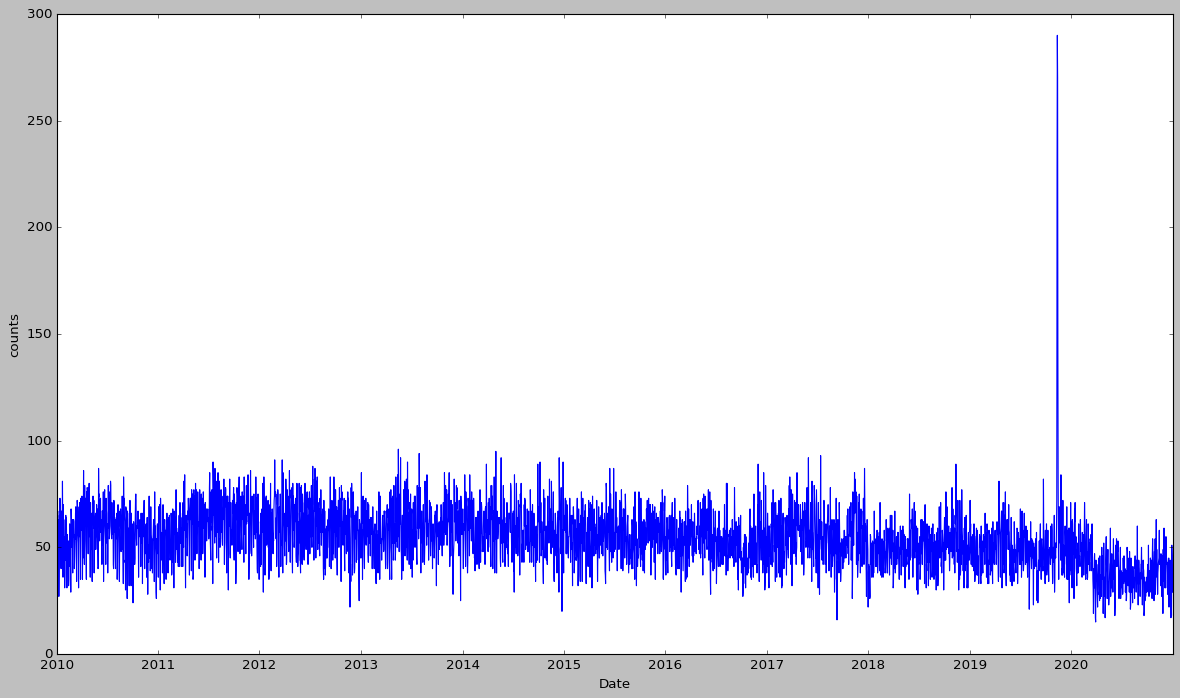

In [161]:
plt.figure(figsize = (18,10))
sns.lineplot(data=crime_vis1_1numday, x="Date", y="counts")
plt.show()

#### 1. Time - 2) Changes in Number of Crimes by Offense Categories

In [195]:
crime_vis1_2numcate = crime_sdf_join2_reindex.groupby(['Date', 'Case Offense Category']).size().reset_index(name='counts')
# Remove outliers for a better visualization
crime_vis1_2numcate_filtered = crime_vis1_2numcate[crime_vis1_2numcate['counts'] < 100]
crime_vis1_2numcate_filtered.head()

,Date,Case Offense Category,counts
0,2010-01-01,Assault,17
1,2010-01-01,Burglary,10
2,2010-01-01,Fraud,2
3,2010-01-01,Narcotics,6
4,2010-01-01,Robbery,1


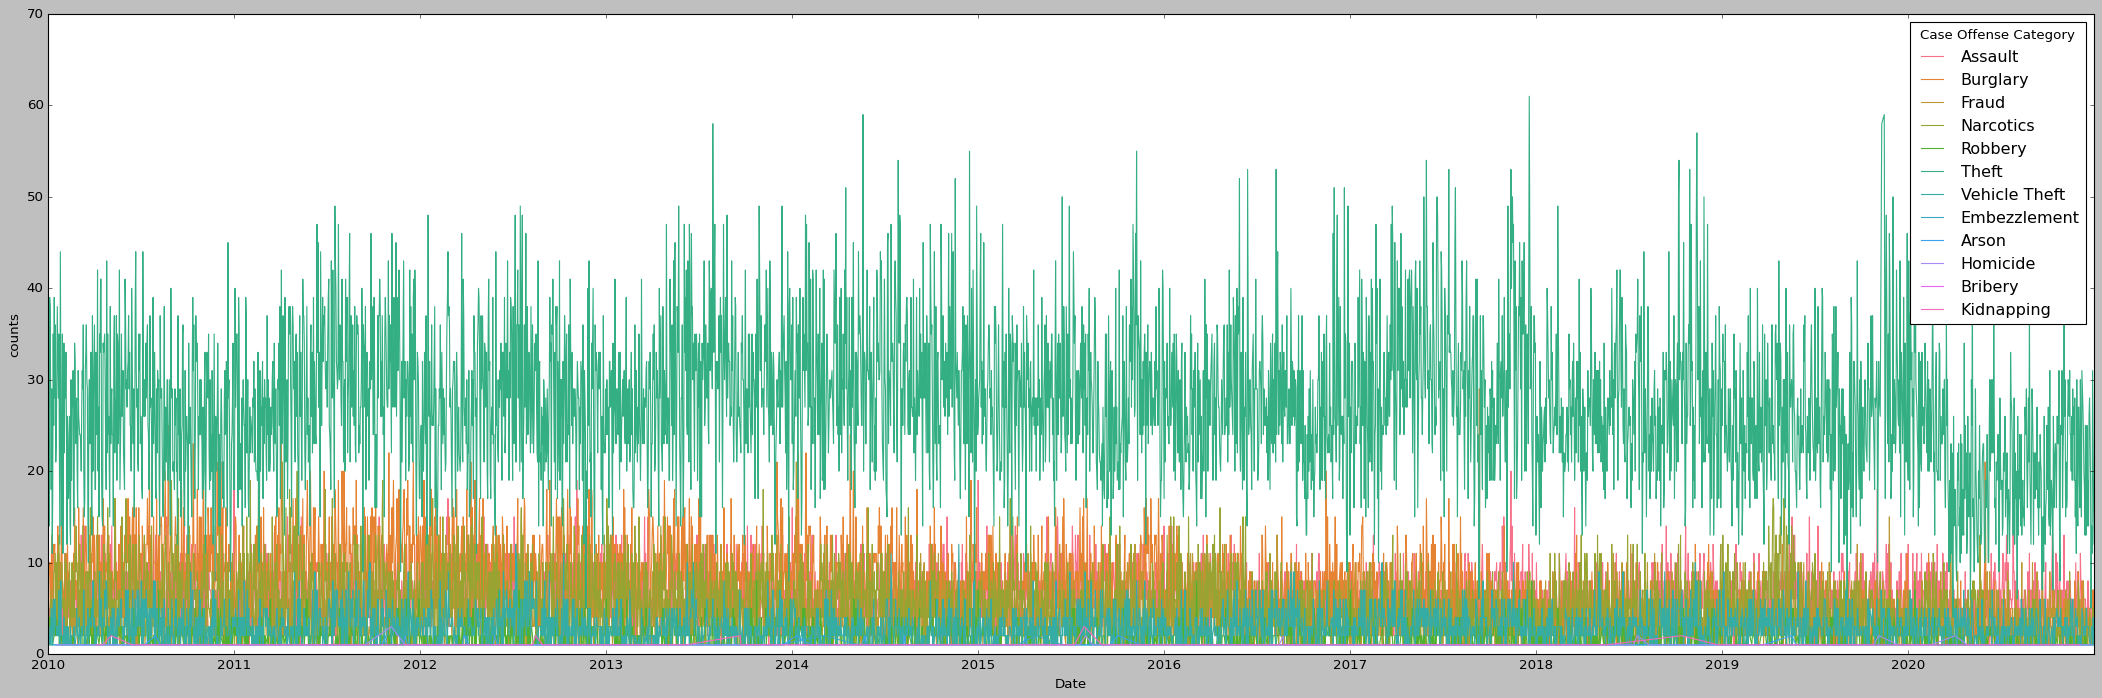

In [201]:
plt.figure(figsize = (33,10))
sns.lineplot(data=crime_vis1_2numcate_filtered, x="Date", y="counts", hue="Case Offense Category")
plt.show()

#### 1. Time - 2) Heatmap by day of week and hour of day

In [202]:
# Craete a heamap of crime incidents by day of week and hour of day in Orlando
crime_vis1_3dayhour = crime_sdf_join2_reindex.groupby(['Weekday', 'Hour']).size().reset_index(name='counts').pivot(index='Weekday', columns='Hour', values='counts').reset_index(drop = True)
crime_vis1_3dayhour = crime_vis1_3dayhour.rename({0: 'Friday', 1: 'Monday', 2:'Saturday', 3:'Sunday', 4:'Thursday', 5:'Tuesday', 6:'Wednesday'}, axis='index').reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
crime_vis1_3dayhour

Hour,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
Monday,810,713,726,491,374,382,707,1345,1992,2231,2374,2413,2345,2283,2279,2181,2066,1748,1751,1483,1286,1280,1038,956
Tuesday,745,648,523,428,324,355,618,1090,1663,1911,2143,2248,2180,2188,2222,2253,2090,1802,1727,1622,1351,1270,1091,924
Wednesday,816,665,682,434,347,344,556,1110,1645,1845,2067,2132,2221,2231,2277,2239,2017,1781,1712,1532,1422,1357,1139,939
Thursday,858,693,732,474,330,353,564,1013,1535,1947,2001,2106,2034,2212,2155,2171,2076,1778,1595,1518,1281,1188,1024,940
Friday,817,743,748,540,335,312,566,972,1517,1840,1917,1969,1973,1978,2109,2059,1890,1712,1643,1439,1414,1279,1282,1157
Saturday,1070,1086,1210,772,510,422,430,667,957,1085,1234,1352,1286,1380,1370,1346,1343,1340,1441,1318,1278,1304,1161,1077
Sunday,1082,1103,1167,778,496,400,359,548,756,942,1171,1221,1278,1276,1296,1273,1313,1332,1300,1351,1168,1115,1009,957


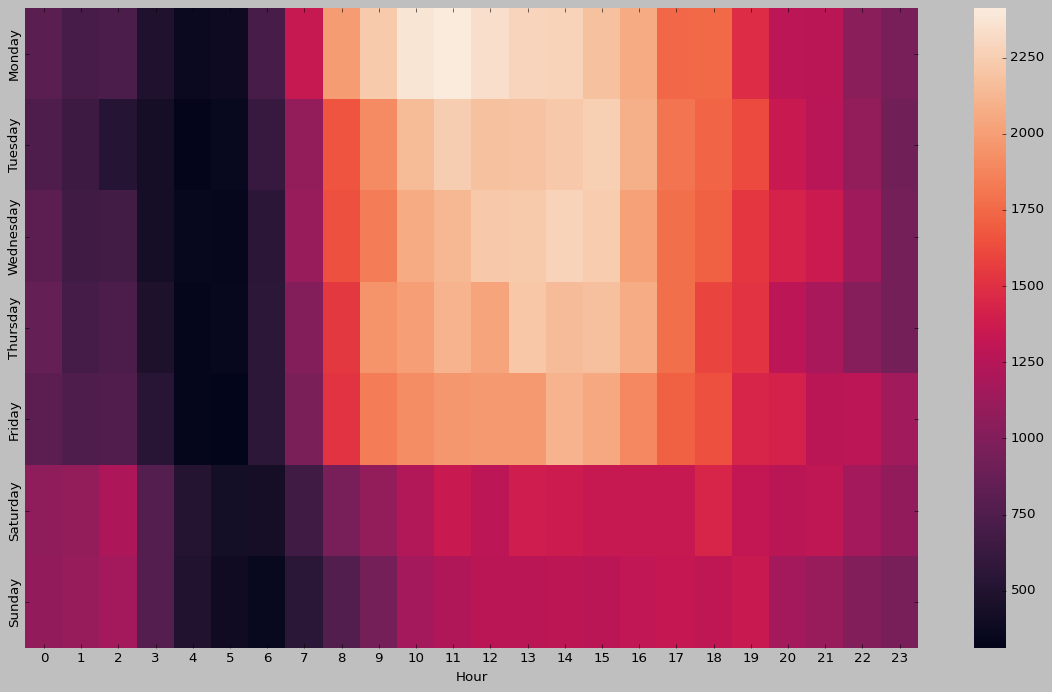

In [203]:
# Heatmap
plt.figure(figsize = (18,10))
ax = sns.heatmap(crime_vis1_3dayhour)
plt.show()

#### 1. Time - 3) Daytime and Nighttime Crime Incidents

#### 2. Location - 1) Number of Crimes / Crime Densities by Neighborhoods

In [204]:
# First, create a dataframe by neighborhoods
crime_vis2_1nbhds = crime_sdf_join2_reindex.groupby(['Neighborhood Name', 'SHAPE_Area']).size().reset_index(name='counts')
crime_vis2_1nbhds['densities'] = crime_vis2_1nbhds['counts'] / crime_vis2_1nbhds['SHAPE_Area']
crime_vis2_1nbhds.head()

,Neighborhood Name,SHAPE_Area,counts,densities
0,33rd St. Industrial,0.000212,1254,5.904645e+06
1,Airport North,0.001452,6606,4.550964e+06
2,Audubon Park,0.000131,657,5.009144e+06
3,Azalea Park,0.000045,273,6.060954e+06
4,Baldwin Park,0.000421,2601,6.178010e+06


In [205]:
# Sort by counts and densities
crime_vis2_1nbhds_counts = crime_vis2_1nbhds.sort_values(by='counts',ascending=False)
crime_vis2_1nbhds_densities = crime_vis2_1nbhds.sort_values(by='densities',ascending=False)

# Create a list for Top 10 Neighborhoods of Counts and Densities
crime_vis2_1nbhds_counts_10 = crime_vis2_1nbhds_counts.iloc[0:10, 0:1].rename(columns = {'Neighborhood Name': "Top 10 Crime Numbers"})
crime_vis2_1nbhds_densities_10 = crime_vis2_1nbhds_densities.iloc[0:10, 0:1].rename(columns = {'Neighborhood Name': "Top 10 Crime Densities"})

pd.concat([crime_vis2_1nbhds_counts_10.reset_index(drop=True), crime_vis2_1nbhds_densities_10.reset_index(drop=True)], axis=1)

,Top 10 Crime Numbers,Top 10 Crime Densities
0,Florida Center,Central Business District
1,Central Business District,Holden/Parramore
2,Metro West,Lake Dot
3,Holden/Parramore,Callahan
4,Millenia,Camellia Gardens
5,Colonial Town Center,South Eola
6,Airport North,Lake Fredrica
7,ORLANDO INTERNATIONAL AIRPORT,Colonial Town Center
8,South Semoran,The Willows
9,Florida Center North,Lorna Doone


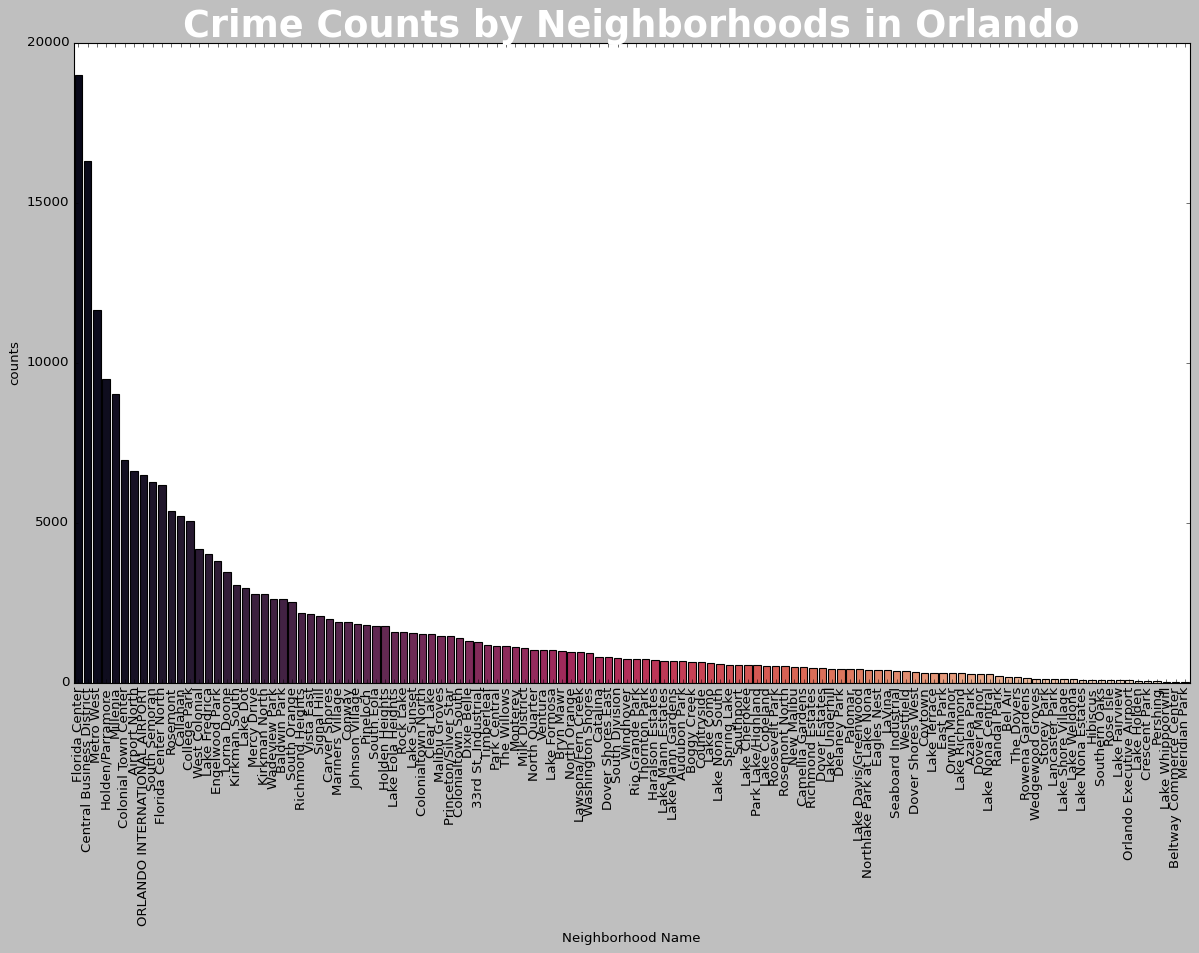

In [206]:
# Create plots - 1) Number of Crimes by Neighborhoods
plt.figure(figsize = (18,10))
ax = sns.barplot(x='Neighborhood Name', y='counts', data=crime_vis2_1nbhds_counts, palette="rocket")
plt.xticks(rotation=90)
plt.title("Crime Counts by Neighborhoods in Orlando", fontsize = 33, fontweight = 'bold', color ='white')
plt.show()

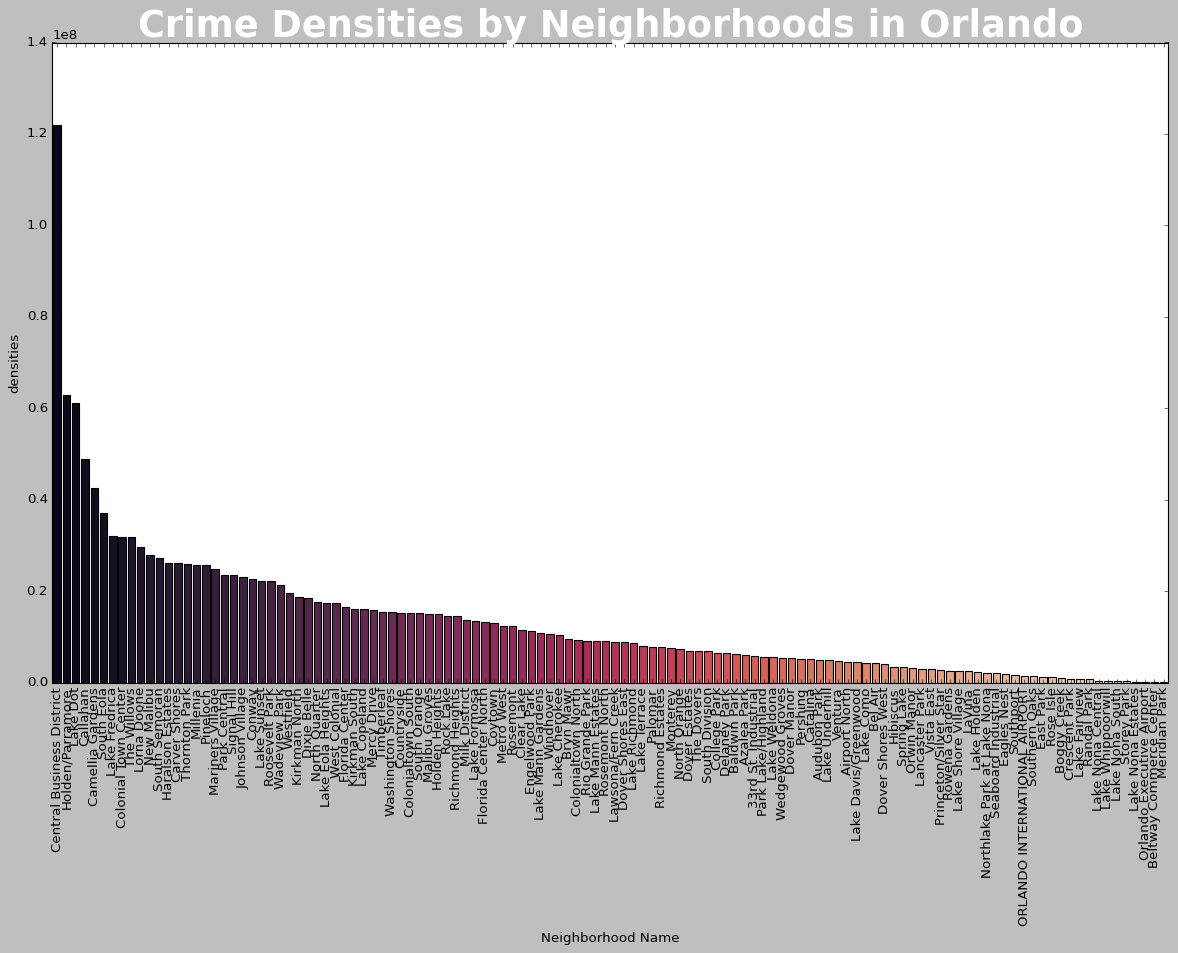

In [207]:
# Create plots - 2) Crimes Densities by Neighborhoods
plt.figure(figsize = (18,10))
ax = sns.barplot(x='Neighborhood Name', y='densities', data=crime_vis2_1nbhds_densities, palette="rocket")
plt.xticks(rotation=90)
plt.title("Crime Densities by Neighborhoods in Orlando", fontsize = 33, fontweight = 'bold', color ='white')
plt.show()

#### 2. Location - 2) Number of Crimes / Crime Densities by Neighborhoods

#### 3. Socio-economic - 1)

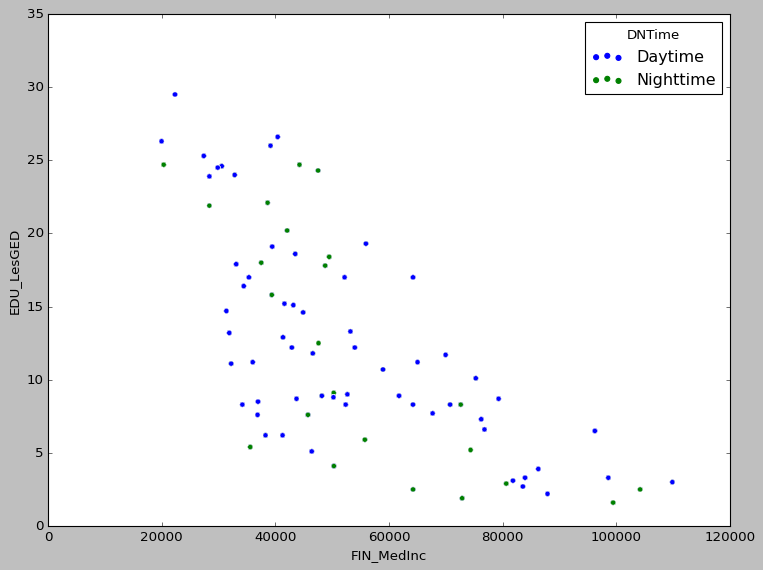

In [208]:
# Create simple scatter plots for crimes
plt.figure(figsize = (11,8))
sns.scatterplot(data = crime_sdf_join2_reindex, x ="FIN_MedInc", y="EDU_LesGED", hue="DNTime")
plt.show()

### 4. Crime Analysis

#### 1) Kernel Density and Minus

#### 2) 80-20 Analysis

### * Other Visualization

#### 1. Time - 2) Crime Day time and Night time 

In [ ]:
# Create Charts for 
crime_sdf_join2_reindex

### * Other Codes

In [ ]:
# b-1. Total crime cases from 2010 to 2020
crime_Date_df1 = crime_analysis_df1.groupby(['Date']).size().reset_index().rename(columns={0: 'Crime Incidents'})
crime_Date_df1

In [ ]:
# Assign plot size
plt.figure(figsize = (15,8))

# Assign styles
sns.set_style("darkgrid")
pal = sns.color_palette('Set2', 12)

# Create line-plot
sns.lineplot(data=crime_Date_df1, 
             x="Date", y="Crime Incidents",
            palette=pal)

# Shows the plot
plt.show()

In [ ]:
# b-2. Total crime cases by Case Offense Category from 2010 to 2020
crime_Date_df2 = crime_analysis_df1.groupby(['Date', 'Case Offense Category']).size().reset_index().rename(columns={0: 'Crime Incidents'})
crime_Date_df2.dtypes

In [ ]:
# Plot from 2010 to 2020
# Assign plot size
plt.figure(figsize = (18,10))

# Assign styles
sns.set_style("darkgrid")
pal = sns.color_palette('Set2', 12)
sns.set(rc={'axes.facecolor': 'darkgray'})

# Create line-plot
sns.lineplot(data=crime_Date_df2, 
             x="Date", y="Crime Incidents", hue='Case Offense Category',
            palette=pal)

# Shows the plot
plt.show()

In [ ]:
# b-3. Create a subset Crime Data in 2020
crime_Date_df3 = crime_Date_df2
crime_Date_df3['Date'] = pd.to_datetime(crime_Date_df3['Date'])
crime_Date_df3 = crime_Date_df3.loc[crime_Date_df3['Date'].dt.year >= 2020]
crime_Date_df3.head()

In [ ]:
# Plot in 2020
# Assign plot size
plt.figure(figsize = (18,10))

# Assign styles
sns.set_style("whitegrid")
pal = sns.color_palette('Set2', 11)
sns.set(rc={'axes.facecolor': 'darkgray'})

# Create line-plot
sns.lineplot(data=crime_Date_df3, 
             x="Date", y="Crime Incidents", hue='Case Offense Category',
            palette=pal)

# Shows the plot
plt.show()

In [ ]:
# Converted 
crime_Date_df3_1=crime_Date_df3.pivot(index='Date', columns='Case Offense Category', values='Crime Incidents').reset_index()
crime_Date_df3_1.head()

In [ ]:
# Theft
crime_Date_df3_2 = crime_Date_df3_1.loc[:, ['Date', 'Theft']].reset_index(drop=True).rename_axis('',axis=1).set_index('Date', drop=True)
crime_Date_df3_2.head()

In [ ]:
plt.figure(figsize=(8,16))

crime_Date_df3_2.plot()
crime_Date_df3_2.rolling(30).mean().plot(style='--');

plt.show()

In [ ]:
crime_Date_df2['Date'] = pd.to_datetime(crime_Date_df2['Date'])
crime_Date_df2_1=crime_Date_df2.pivot(index='Date', columns='Case Offense Category', values='Crime Incidents').reset_index()
crime_Date_df2_1.head()

In [ ]:
crime_Date_df2['Date'] = pd.to_datetime(crime_Date_df2['Date'])
crime_Date_df2_1=crime_Date_df2.pivot(index='Date', columns='Case Offense Category', values='Crime Incidents').reset_index()
crime_Date_df2_2 = crime_Date_df2_1.loc[:, ['Date', 'Theft']].reset_index(drop=True).rename_axis('',axis=1).set_index('Date', drop=True)
crime_Date_df2_2.head()

In [ ]:
plt.figure(figsize=(20,10))

crime_Date_df2_2.plot()
crime_Date_df2_2.rolling(250).mean().plot(style='--');

plt.show()